In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms
from torchinfo import summary

from module.train import fit, test_multi_classification
from module.utils import plot_fit_result

import os

device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

# 하이퍼파라미터

In [4]:
epochs = 5
batch_size = 40
lr = 0.001

save_best_model = True
save_model_path = r"C:\Documents\deeplearning\saved_models"
early_stopping = False
patience = 10
data_path = r"C:\Classes\deeplearning\datasets"

# Transformer, Dataset

In [5]:
transform = transforms.Compose([
    # 32 x 32 -> 224 x 224 해상도를 올림.(성능은 개선, 메모리가 많이 필요.). PT 모델 ImageNet(224 x 224)으로 학습
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)  # PIXCEL * 0/5(표준편차) - 0.5(평균)
])

train_set = datasets.CIFAR10(data_path, train=True, transform=transform, download=True)
test_set = datasets.CIFAR10(data_path, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(train_set.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# DataLoader

In [6]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_set, batch_size, num_workers=os.cpu_count())

### Image 확인

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
images, labels = next(iter(train_loader))  # train set에서 배치 크기(40)만큼 loading 

print(images.shape)

In [8]:
print(images.shape)

torch.Size([40, 3, 224, 224])


In [10]:
torchvision.utils.make_grid?

Signature:
torchvision.utils.make_grid(
    tensor: Union[torch.Tensor, List[torch.Tensor]],
    nrow: int = 8,
    padding: int = 2,
    normalize: bool = False,
    value_range: Optional[Tuple[int, int]] = None,
    scale_each: bool = False,
    pad_value: float = 0.0,
) -> torch.Tensor
Docstring:
Make a grid of images.

Args:
    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    nrow (int, optional): Number of images displayed in each row of the grid.
        The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
    padding (int, optional): amount of padding. Default: ``2``.
    normalize (bool, optional): If True, shift the image to the range (0, 1),
        by the min and max values specified by ``value_range``. Default: ``False``.
    value_range (tuple, optional): tuple (min, max) where min and max are numbers,
        then these numbers are used to normalize the image. By default, min and max
    

torch.Size([3, 1132, 1810])


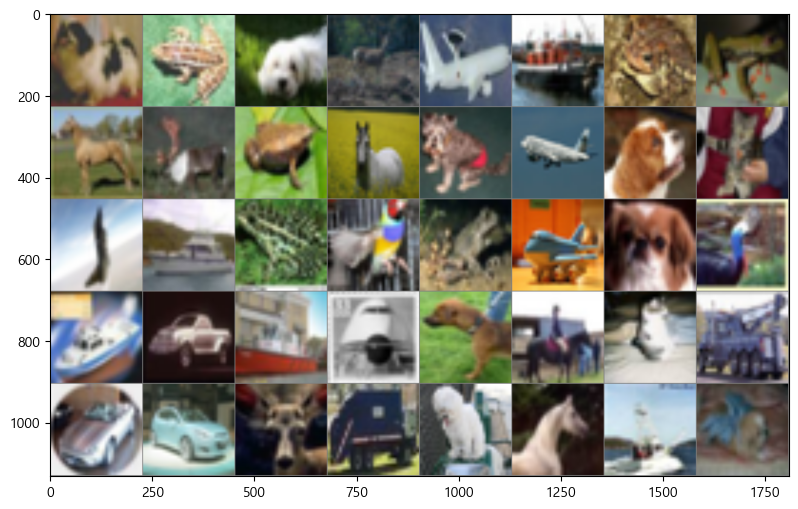

In [11]:
concat_img = torchvision.utils.make_grid(images)  # image들을 합쳐서 하나의 tensor로 만든다.
print(concat_img.shape)

concat_img = concat_img / 2 + 0.5     # unnormalize,   normalize = x * 표준편차 - 평균
img_arr = concat_img.numpy()  # Tensor -> ndarray

plt.figure(figsize=(13, 6))
plt.imshow(np.transpose(img_arr, (1, 2, 0)))
plt.show()

# Modeld 정의

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) 
summary(model, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

##  frozon

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

## classifier 변경

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
a = nn.Linear(10, 2)
a.in_features, a. out_features

(10, 2)

In [18]:
in_features = model.fc.in_features
print(in_features)

### 출력 Layer 변경
model.fc = nn.Linear(in_features, 10)

512


In [19]:
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

#  학습

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # momentum
scheduler = None

In [ ]:
result = fit(train_loader, test_loader, model, loss_fn, optimizer, epochs, 
                save_best_model=save_best_model, save_model_path=os.path.join(save_model_path, "cifar10_resnet18.pth"),
                early_stopping=early_stopping,patience=patience, 
                mode="multi",
                device=device, lr_scheduler=scheduler)

### 학습한 모델 Loading

In [42]:
%%writefile module/utils.py

import matplotlib.pyplot as plt
import torch 
from PIL import Image

def predict_image(image_path, model, transform, device):
    """
    image_path의 이미지를 model을 이용해서 추론.
    Parameter
        image_path: 추론할 이미지 경로
        model: 학습된 모델
        transform: 추론전 전처리 할 transform 
        device
    Return
        tuple: (class_index, 확률)
    """
    # 이미지 로딩
    img = Image.open(image_path)
    # 전처리
    input_data = transform(img)
    # batch 축 늘리기. (C, H, W) -> (1, C, H, W)
    input_data = input_data.unsqueeze(dim=0)
    input_data = input_data.to(device)

    # 추론
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(input_data).softmax(dim=-1)    # 추론결과(logit)을 확률값으로 변경.
        pred_class = pred.argmax(dim=-1).item()       # 정답 class
        pred_proba = pred.max(dim=-1).values.item() # 모델이 추정한 정답의 확률
        return pred_class, pred_proba  # 정답 class_index,  정답의 확률


def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()


Overwriting module/utils.py


In [7]:
best_model = torch.load('saved_models/cifar10_resnet18.pth', map_location=torch.device(device))

0 , 0.99812251329422 , airplane


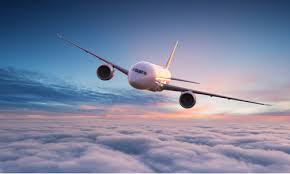

In [18]:
from module import utils
from PIL import Image
# test_img = 'test_img/car.jpg'
# test_img = 'test_img/dog.jpg'
test_img = "test_img/cat.jpg"
test_img = "test_img/frog.jpg"
test_img = "test_img/frog2.jpg"
test_img = "test_img/airplane.jpg"
test_img = "test_img/airplane2.jpg"
class_idx, proba = utils.predict_image(test_img, best_model, transform, device)
print(class_idx, proba, train_set.classes[class_idx], sep=" , ")
Image.open(test_img)

In [52]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [43]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 